# Import Libraries

In [1]:
import os
import seaborn as sns
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D

from scipy.stats.mstats import winsorize
from scipy.interpolate import griddata

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, ReLU, GlobalAveragePooling1D, Dense, Dropout, MaxPool1D, Flatten
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.schedules import ExponentialDecay

import pickle as pkl

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Functions

In [136]:
## Extracting list of chemical elements
def elem_list(df):
    str_elem = []
    
    for col in list(df.columns):
        if col not in ['gid', 
                       'objectid', 
                       'sampleno', 
                       'longitude', 
                       'latitude', 
                       'toposheet']:
            str_elem.append(col)

    return str_elem

## Element concentration variation
def plot_ppm_variation(df, element):
    lat_list = np.sort(df['latitude'].unique())[::-1]
    
    for lat in lat_list:
        subset = df[df['latitude'] == lat].sort_values(by='longitude')
        plt.figure(figsize=(10, 2))
        plt.plot(subset['longitude'], subset[element], marker='o', linestyle='-', color='b')
        plt.title(f'Concentration at Latitude {lat}')
        plt.xlabel('Longitude')
        plt.ylabel(f'Concentration(ppm)')
        plt.grid(True)
        plt.show()

## Contour maps
def plot_contour(df, element, name, title):
    # Check if the element exists in the dataframe
    if element not in df.columns:
        raise KeyError(f"The element '{element}' does not exist in the dataframe.")

    min_lat_limit = min(df['latitude']) - 0.005
    max_lat_limit = max(df['latitude']) + 0.005
    min_long_limit = min(df['longitude']) - 0.005 
    max_long_limit = max(df['longitude']) + 0.005

    grid_x, grid_y = np.mgrid[
        min_long_limit:max_long_limit:200j,  # 200j specifies 200 points in grid
        min_lat_limit:max_lat_limit:200j
    ]

    # Grid interpolation
    grid_z = griddata(
        (df['longitude'], df['latitude']),
        df[element],
        (grid_x, grid_y),
        method='cubic'  # 'cubic' for smoother contour lines
    )

    cmap = LinearSegmentedColormap.from_list("green_to_red", ["green", "yellow", "red"])
    
    plt.figure(figsize=(10, 6))

    # Filled contour
    cp = plt.contourf(grid_x, grid_y, grid_z, levels=15, cmap=cmap, alpha=0.7)
    plt.colorbar(cp, label=f'{name} concentration')

    # Line contours
    cs = plt.contour(grid_x, grid_y, grid_z, levels=15, colors='k', linewidths=0.5)
    plt.clabel(cs, inline=True, fontsize=8, fmt='%1.0f')

    # plt.scatter(df['longitude'], df['latitude'], color='black', s=10)  # Sample points
    
    # Annotate ppm values at each sample point
    # for x, y, ppm in zip(df['longitude'], df['latitude'], df[element]):
    #     plt.text(x, y, f'{ppm:.1f}', color='black', fontsize=8, ha='right')

    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
    
    # Positioning the legend outside the plot area with spacing
    plt.legend(['Sample Points'], loc='upper left', bbox_to_anchor=(1, 1))
    
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

## Outlier handling
def handle_outl(df):

    cols = list(df.columns)
    
    for elem in cols:
        
        Q1 = df[elem].quantile(0.25)
        Q3 = df[elem].quantile(0.75)
        IQR = Q3 - Q1
        lwr_bnd = Q1 - (1.5 * IQR)
        upr_bnd = Q3 + (1.5 * IQR)

        quantiles = {
            87 : df[elem].quantile(0.87), 
            90 : df[elem].quantile(0.90),
            92.5 : df[elem].quantile(0.925),
            95 : df[elem].quantile(0.95),
            97.5 : df[elem].quantile(0.975),
            99 : df[elem].quantile(0.99)
        }
        
        min_diff = float('inf')
        nearest_key = None
        for key, val in quantiles.items():
        
            if val >= upr_bnd:
                diff = val - upr_bnd
                if diff < min_diff:
                    min_diff = diff
                    nearest_key = key
        
        if nearest_key is None:
            df[elem] = df[elem].apply(lambda x: upr_bnd if x > upr_bnd else x)
            continue
        
        nearest_key = (100 - nearest_key) / 100
        nearest_key = np.round(nearest_key, 3)
        df[elem] = winsorize(df[elem], limits=(0.05, nearest_key))

    return df

## Recursive Feature Elimination with Cross-Validation
def rfecv(estimator, X, y, step, cv):
    rfecv = RFECV(estimator=estimator, 
                  step=step, 
                  cv=KFold(cv, 
                           shuffle=True, 
                           random_state=42),
                  scoring='neg_mean_squared_error')
    rfecv.fit(X, y)
    return rfecv

## RFECV for classification
def rfecv_cls(estimator, X, y, step, cv):
    rfecv = RFECV(estimator=estimator, 
                  step=step, 
                  cv=StratifiedKFold(cv), 
                  scoring='accuracy')
    rfecv.fit(X, target)
    return rfecv

## Plotting % of Correct Classification
def plot_pcc(rfecv, title):
    
    plt.figure(figsize=(10, 9))
    plt.title(title, 
              fontsize=18, 
              fontweight='bold', 
              pad=20)
    plt.xlabel('Number of features selected', 
               fontsize=14, 
               labelpad=20)
    plt.ylabel('% Correct Classification', 
               fontsize=14, 
               labelpad=20)
    plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), 
             rfecv.cv_results_['mean_test_score'], 
             color='#303F9F', 
             linewidth=3)
    
    plt.show()

## Plotting feature importances
def feature_importance(rfecv, X, title): 
        
    df = pd.DataFrame()
    
    df['column'] = X.columns
    df['importance'] = rfecv.estimator_.feature_importances_
    
    df.sort_values(by='importance', 
                   ascending=False, 
                   inplace=True, 
                   ignore_index=True)
    
    sns.set(rc = {'figure.figsize':(8,10)})
    ax = sns.barplot(y='column', 
                     x='importance',
                     data=df,
                     palette='viridis')
    
    ax.set_title(title, 
                 fontsize=18)

## Predicting validation data
def pred_val(df, columns, sc, model):

    scaled_df = sc.transform(df)
    
    scaled_df = pd.DataFrame(scaled_df, 
                             columns=df.columns)
    
    scaled_df = scaled_df[columns]

    # pca_df = pca.transform(scaled_df)

    y_pred = model.predict(scaled_df)

    return y_pred

## Train vs Val loss
def metrics_graph(model, num_epoch):
    
    r_ep = range(num_epoch)
    train_loss = model.history['loss']
    validation_loss = model.history['val_loss']

    plt.figure(figsize=(15,7))
    
    plt.subplot(1, 2, 1)
    plt.title('Train vs Validation')
    plt.plot(r_ep, train_loss)
    plt.plot(r_ep, validation_loss)
    plt.legend(['train_loss', 'val_loss'])
    plt.xlabel('No. of epochs')
    plt.ylabel('Loss')

## Multiple loss functions
def r2_score(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - (ss_res / (ss_tot + tf.keras.backend.epsilon()))

def median_absolute_error(y_true, y_pred):
    error = tf.abs(y_true - y_pred)
    return tf.numpy_function(np.median, [error], tf.float32)

# Load Data

### Train Data

In [4]:
curr_dir = (os.getcwd()).replace('\\', '/')
data_path = (os.path.join(curr_dir, 'Data')).replace('\\', '/')

In [5]:
str_sed_data = pd.read_csv(data_path + '/Ramagiri dataset/stream_sediments_57F11.csv')

In [6]:
str_sed_data.head()

,gid,objectid,sampleno,longitude,latitude,sio2,al2o3,fe2o3,tio2,cao,...,u,pt,pd,toposheet,in_,f,te,tl,hg,cd
0,2947,2947,57F11/177/SS/12,77.657407,14.475225,61.921,14.606,4.51,0.05,2.28,...,3.016905,0,0,57F11,0,0,0,0,8.0,50
1,2948,2948,57F11/178/SS/12,77.675926,14.475225,62.077,13.750,4.22,0.05,2.43,...,3.378550,0,0,57F11,0,0,0,0,9.0,50
2,2949,2949,57F11/179/SS/12,77.694444,14.475225,68.645,13.410,3.02,0.05,1.32,...,3.509000,0,0,57F11,0,0,0,0,2.5,50
3,2950,2950,57F11/180/SS/12,77.712963,14.475225,64.950,14.280,3.46,0.05,1.75,...,4.241000,0,0,57F11,0,0,0,0,19.0,50
4,2951,2951,57F11/181/SS/12,77.731481,14.475225,64.302,14.010,4.08,0.05,1.84,...,4.218000,0,0,57F11,0,0,0,0,19.0,50


### Test Data

In [10]:
test_data = pd.read_csv(data_path + '/Ramagiri dataset//gcm_CR_57f11.csv')

In [13]:
test_data.head()

,gid,objectid_1,ssampleno,type,longitude,latitude,SiO2,Al2O3,Fe2O3,TiO2,...,Pt,Pd,Soi_No.,F,In,Te,Tl,Cd,Hg,View on Map
0,2277,247676,57F11/A1/R/12,Regolith,77.5417,14.4583,46.35,21.43,12.24,1.15,...,0,0,57F11,0,0,0,0,NaN,NaN,NaN
1,2278,247677,57F11/A2/R/12,Regolith,77.5417,14.3750,43.29,24.93,15.26,1.06,...,0,0,57F11,0,0,0,0,NaN,NaN,NaN
2,2279,247678,57F11/A3/R/12,Regolith,77.5417,14.2917,57.83,17.57,5.42,0.79,...,0,0,57F11,0,0,0,0,NaN,NaN,NaN
3,2280,247679,57F11/A4/R/12,Regolith,77.6250,14.4583,48.06,20.14,10.82,0.56,...,0,0,57F11,0,0,0,0,NaN,NaN,NaN
4,2281,247680,57F11/A5/R/12,Regolith,77.6250,14.3750,61.78,16.94,5.75,0.71,...,0,0,57F11,0,0,0,0,NaN,NaN,NaN


# EDA

In [7]:
rem_elem = []
for col in str_sed_data.columns:
    if (str_sed_data[col] == 0).all():
        rem_elem.append(col)
print(f"Elements which don't contribute in the sediment composition: {rem_elem}")

Elements which don't contribute in the sediment composition: ['pt', 'pd', 'in_', 'f', 'te', 'tl']


In [8]:
str_sed_data.drop(rem_elem, axis=1, inplace=True)

In [9]:
str_sed_data.head()

,gid,objectid,sampleno,longitude,latitude,sio2,al2o3,fe2o3,tio2,cao,...,tm,yb,lu,hf,ta,w,u,toposheet,hg,cd
0,2947,2947,57F11/177/SS/12,77.657407,14.475225,61.921,14.606,4.51,0.05,2.28,...,0.359742,2.290226,0.413697,26.874492,0.677483,2.5,3.016905,57F11,8.0,50
1,2948,2948,57F11/178/SS/12,77.675926,14.475225,62.077,13.750,4.22,0.05,2.43,...,0.419132,2.891123,0.500104,37.079419,0.774466,2.5,3.378550,57F11,9.0,50
2,2949,2949,57F11/179/SS/12,77.694444,14.475225,68.645,13.410,3.02,0.05,1.32,...,0.329000,2.323000,0.423000,23.652000,0.715000,2.5,3.509000,57F11,2.5,50
3,2950,2950,57F11/180/SS/12,77.712963,14.475225,64.950,14.280,3.46,0.05,1.75,...,0.306000,2.186000,0.400000,21.961000,0.744000,2.5,4.241000,57F11,19.0,50
4,2951,2951,57F11/181/SS/12,77.731481,14.475225,64.302,14.010,4.08,0.05,1.84,...,0.334000,2.322000,0.431000,26.705000,0.832000,2.5,4.218000,57F11,19.0,50


In [10]:
str_elem = elem_list(str_sed_data)
len(str_elem)

59

In [11]:
zero_count_features = (str_sed_data[str_elem] == 0).sum()
df = zero_count_features[zero_count_features > 1]
mis_val_col = df.index.to_list()
mis_val_col

['li', 'cs', 'as_', 'sb', 'bi', 'se']

All the missing values in the above elements are in the same samples. Hence we drop them.

In [12]:
rows = (str_sed_data[mis_val_col] == 0).any(axis=1)
str_sed_data = str_sed_data[~rows]
str_sed_data.shape

(200, 65)

In [13]:
str_sed_data.tail()

,gid,objectid,sampleno,longitude,latitude,sio2,al2o3,fe2o3,tio2,cao,...,tm,yb,lu,hf,ta,w,u,toposheet,hg,cd
198,4774,4774,57F07/028/SS/12,77.5,14.277027,67.670,14.14,3.42,0.05,1.29,...,0.418,2.669,0.435,12.326000,1.009,2.5,3.255,57F07,2.5,50
199,4788,4788,57F07/042/SS/12,77.5,14.295045,66.980,12.88,4.86,0.06,1.28,...,0.363,2.251,0.352,11.946000,1.663,2.5,4.438,57F07,5.0,50
200,4970,4970,57F07/014/SS/12,77.5,14.259009,66.624,15.01,3.29,0.07,0.98,...,0.516,3.423,0.540,9.460000,1.612,2.5,3.479,57F07,2.5,50
201,5059,5059,57F07/056/SS/12,77.5,14.313063,62.050,14.09,5.30,0.09,1.72,...,0.562,3.336,0.546,16.966999,1.762,2.5,5.554,57F07,8.0,50
202,5073,5073,57F07/070/SS/12,77.5,14.331081,64.030,12.09,2.74,0.05,2.66,...,0.453,2.905,0.509,25.667000,0.895,2.5,4.153,57F07,2.5,50


In [14]:
str_sed_data.reset_index(inplace=True, drop='index')

In [15]:
str_sed_data.tail()

,gid,objectid,sampleno,longitude,latitude,sio2,al2o3,fe2o3,tio2,cao,...,tm,yb,lu,hf,ta,w,u,toposheet,hg,cd
195,4774,4774,57F07/028/SS/12,77.5,14.277027,67.670,14.14,3.42,0.05,1.29,...,0.418,2.669,0.435,12.326000,1.009,2.5,3.255,57F07,2.5,50
196,4788,4788,57F07/042/SS/12,77.5,14.295045,66.980,12.88,4.86,0.06,1.28,...,0.363,2.251,0.352,11.946000,1.663,2.5,4.438,57F07,5.0,50
197,4970,4970,57F07/014/SS/12,77.5,14.259009,66.624,15.01,3.29,0.07,0.98,...,0.516,3.423,0.540,9.460000,1.612,2.5,3.479,57F07,2.5,50
198,5059,5059,57F07/056/SS/12,77.5,14.313063,62.050,14.09,5.30,0.09,1.72,...,0.562,3.336,0.546,16.966999,1.762,2.5,5.554,57F07,8.0,50
199,5073,5073,57F07/070/SS/12,77.5,14.331081,64.030,12.09,2.74,0.05,2.66,...,0.453,2.905,0.509,25.667000,0.895,2.5,4.153,57F07,2.5,50


In [77]:
stats_df = pd.DataFrame(str_sed_data[['as_', 'au', 'ag', 'pb']].describe())
stats_df.drop(['count', '25%', '50%', '75%'], axis=0, inplace=True)
stats_df = stats_df.rename(columns={'as_' : 'Arsenic', 'au' : 'Gold', 'ag' : 'Silver', 'pb' : 'Lead'})
stats_df

,Arsenic,Gold,Silver,Lead
mean,5.985975,5.002500,32.005000,16.240500
std,8.548271,16.321634,42.384635,3.918723
min,0.050000,1.500000,10.000000,1.000000
max,50.000000,168.000000,396.000000,34.200000


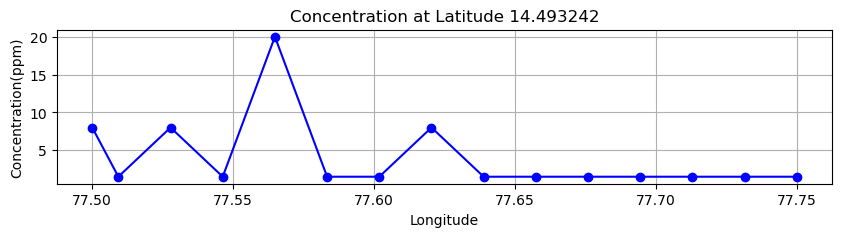

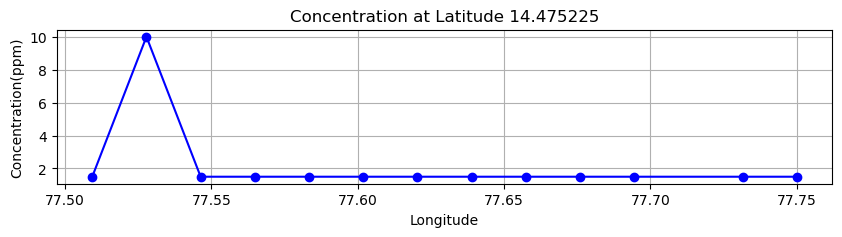

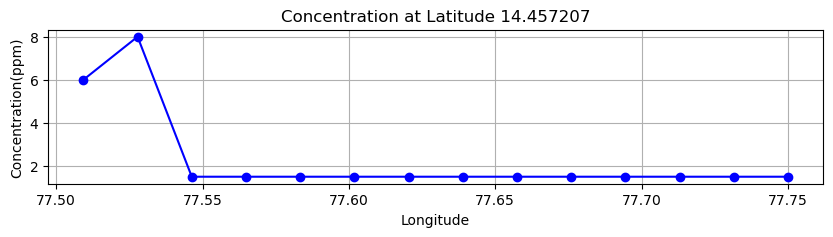

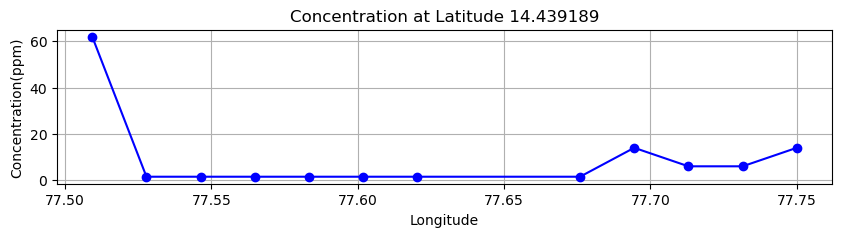

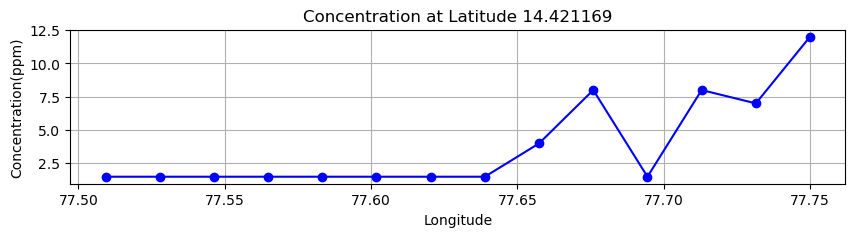

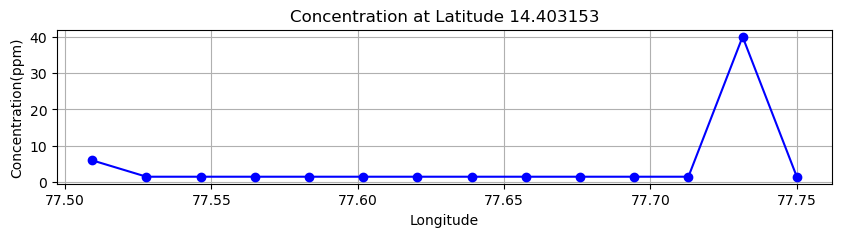

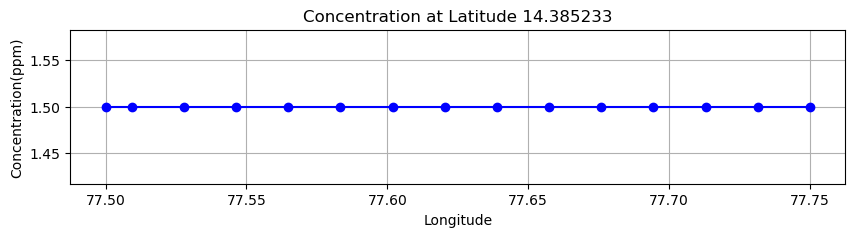

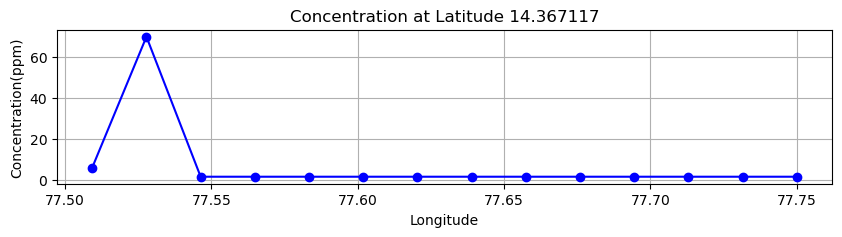

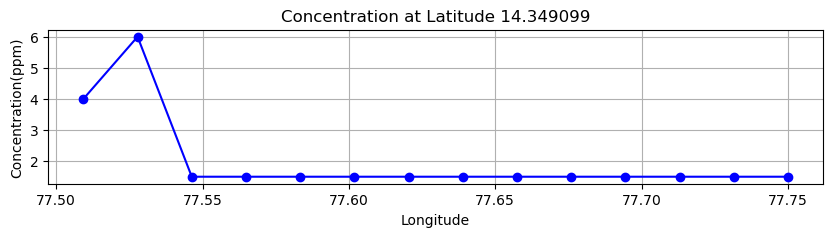

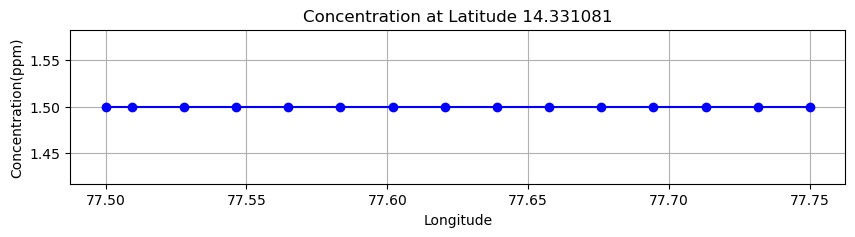

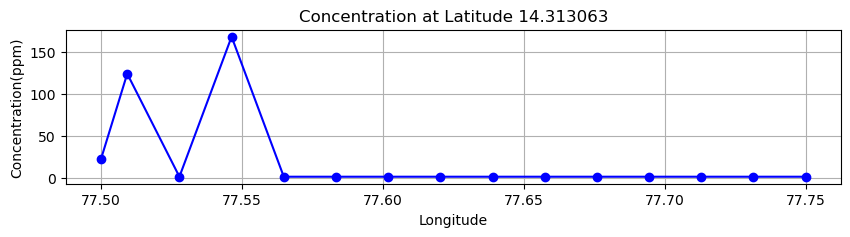

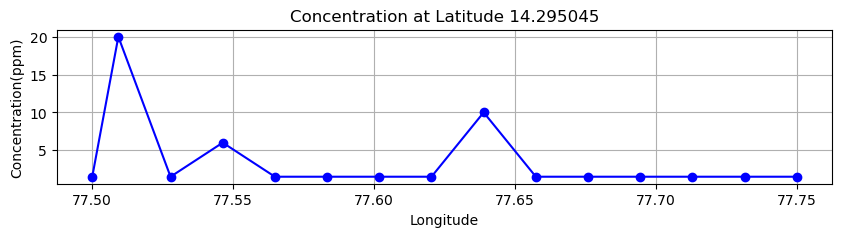

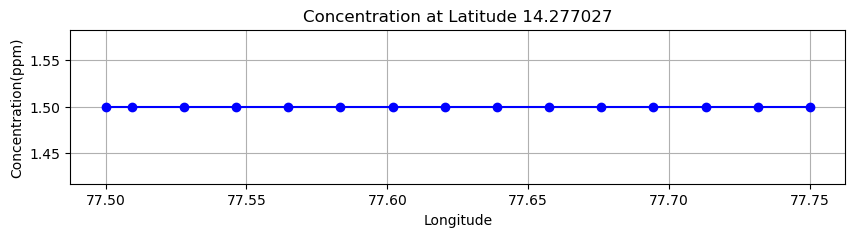

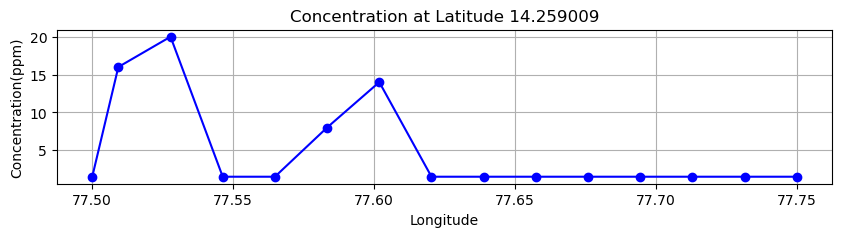

In [61]:
plot_ppm_variation(str_sed_data, 'au')

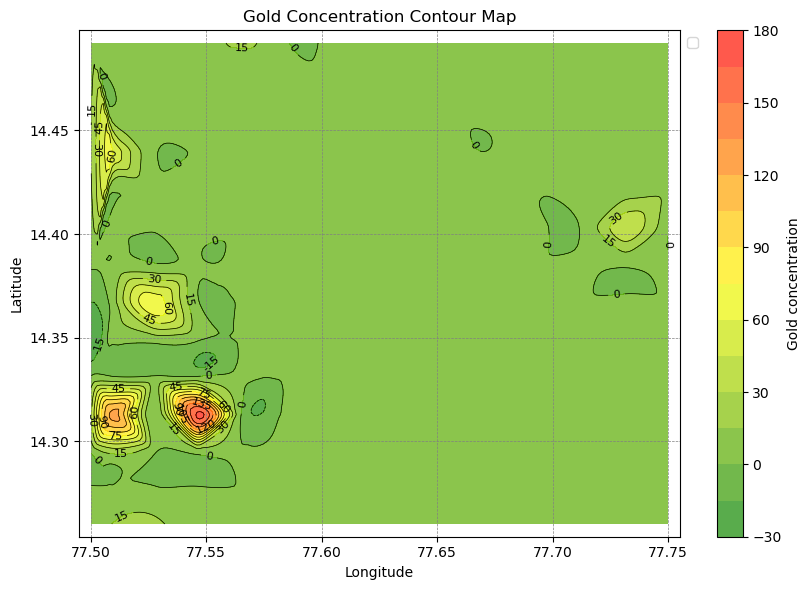

In [137]:
plot_contour(str_sed_data, 'au', 'Gold', 'Gold Concentration Contour Map')

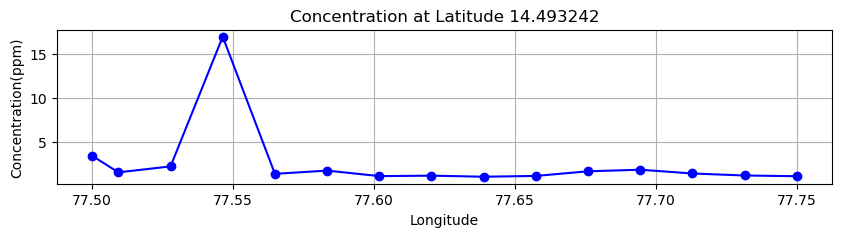

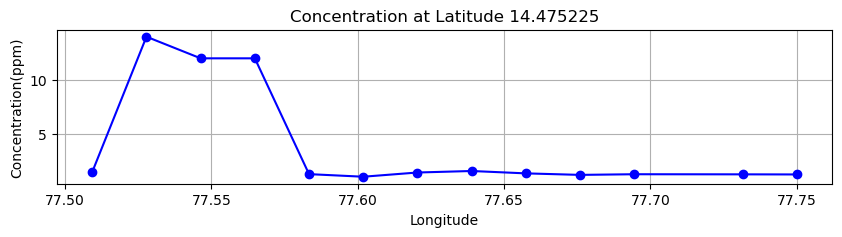

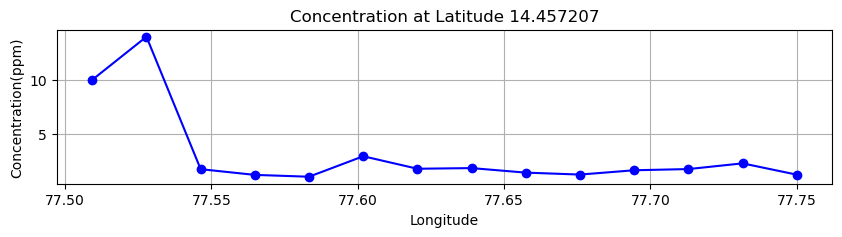

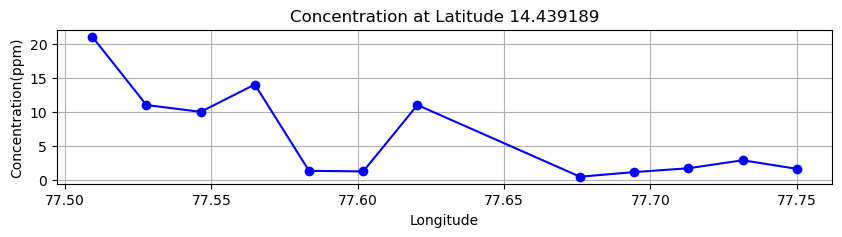

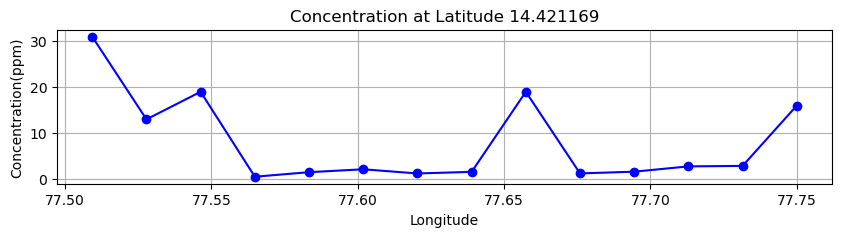

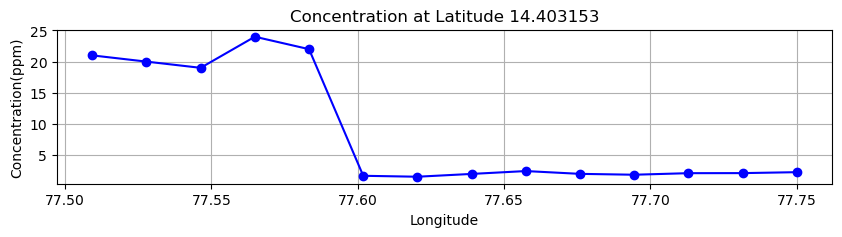

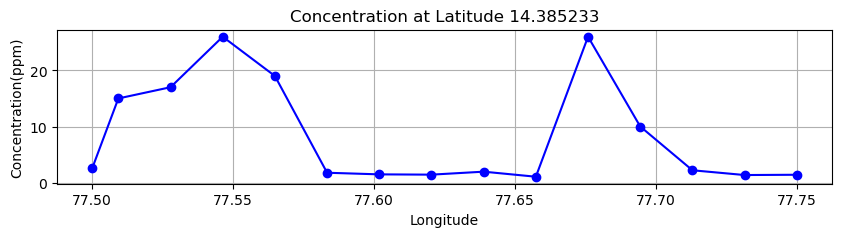

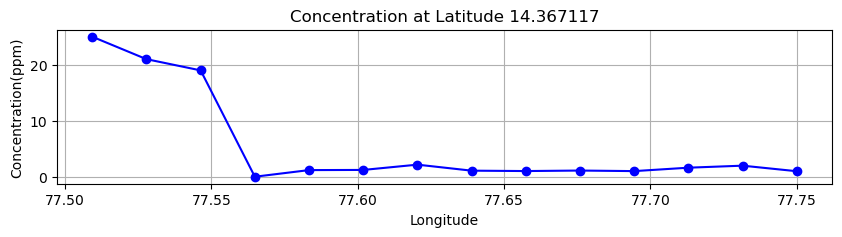

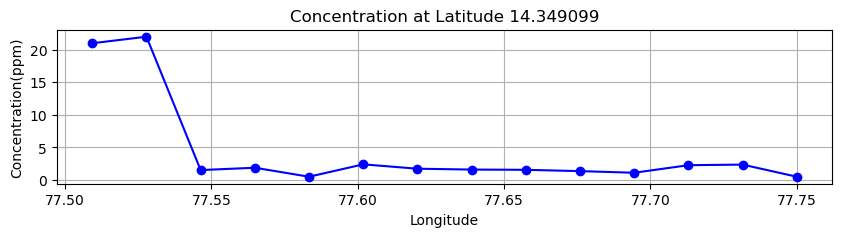

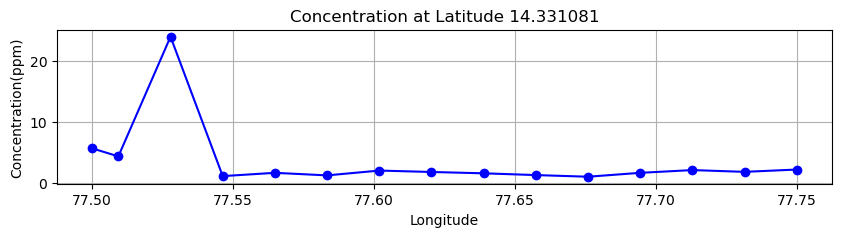

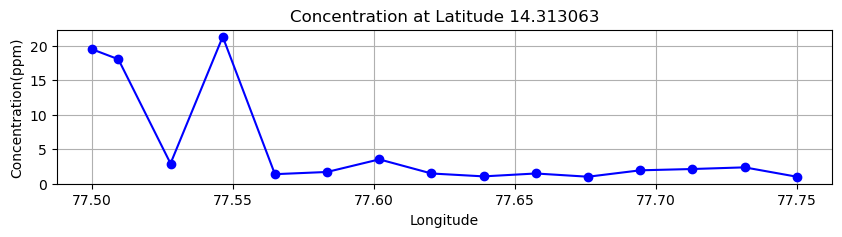

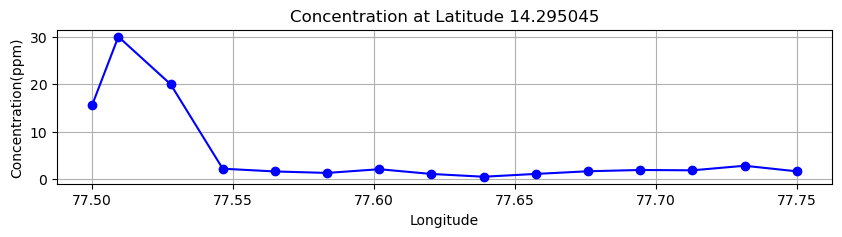

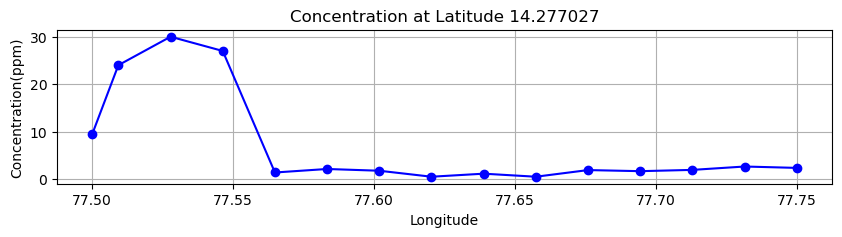

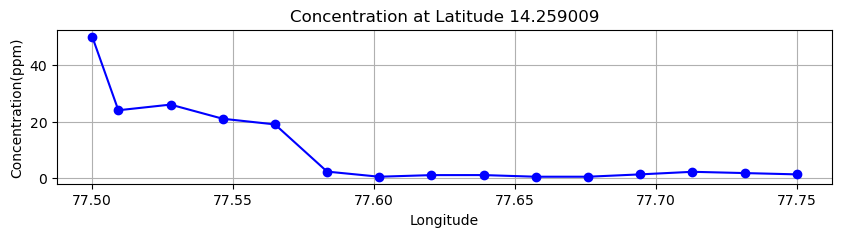

In [62]:
plot_ppm_variation(str_sed_data, 'as_')

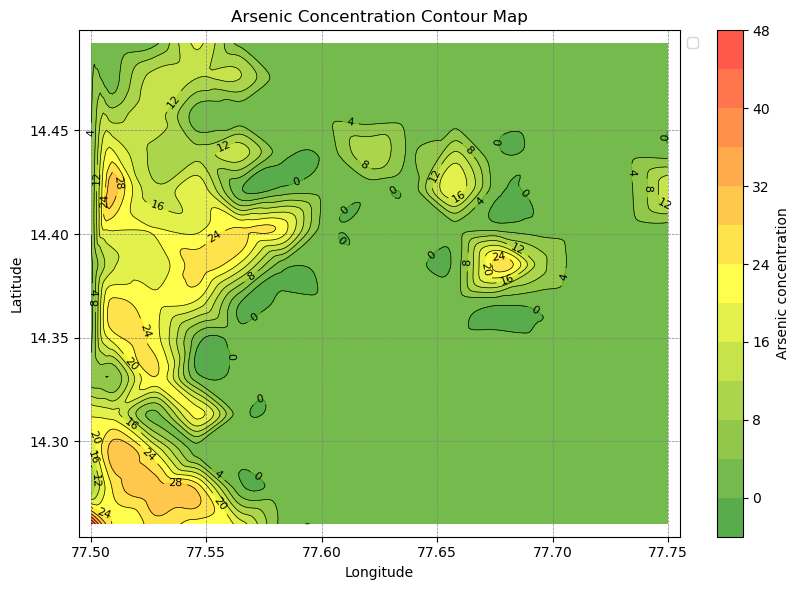

In [138]:
plot_contour(str_sed_data, 'as_', 'Arsenic', 'Arsenic Concentration Contour Map')

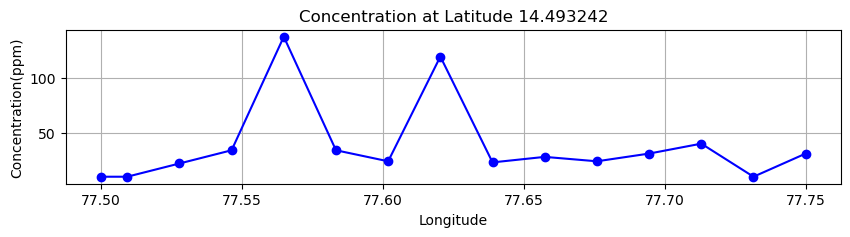

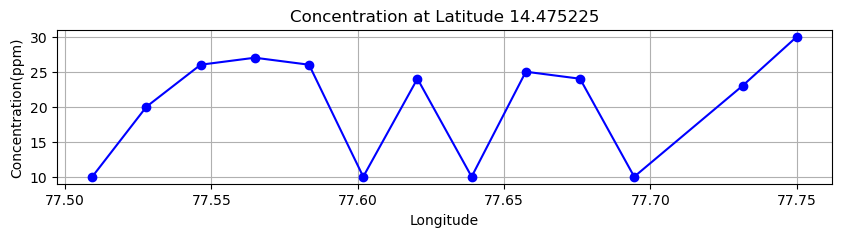

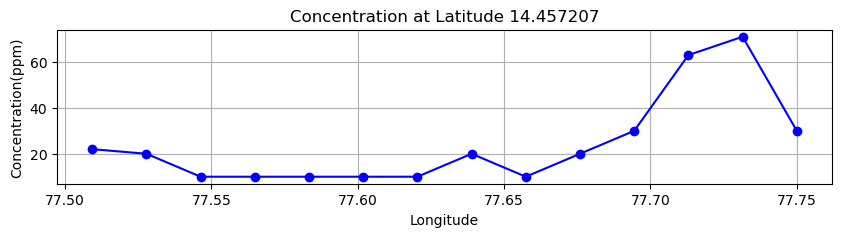

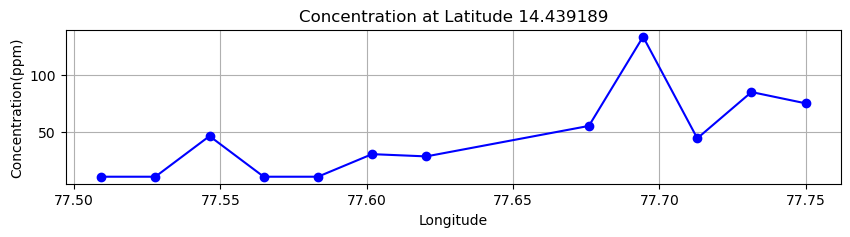

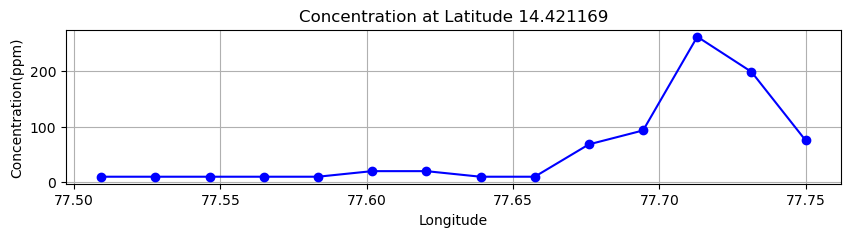

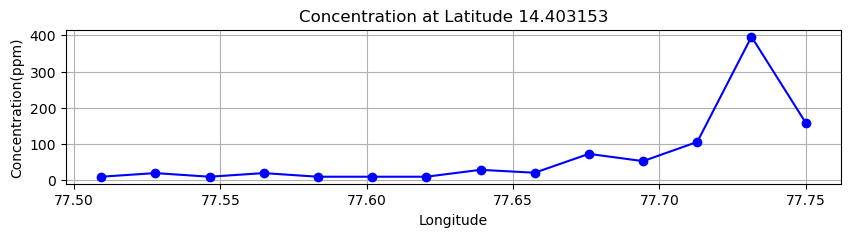

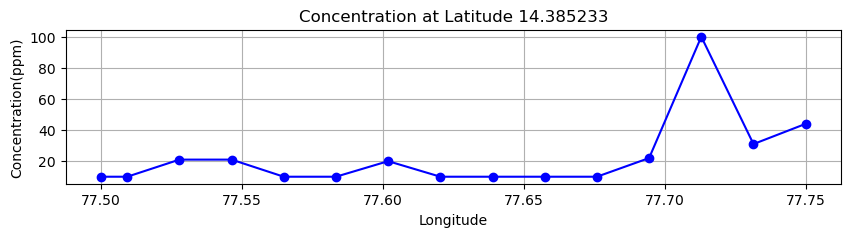

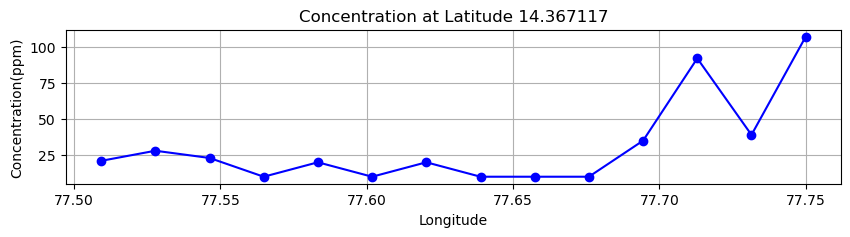

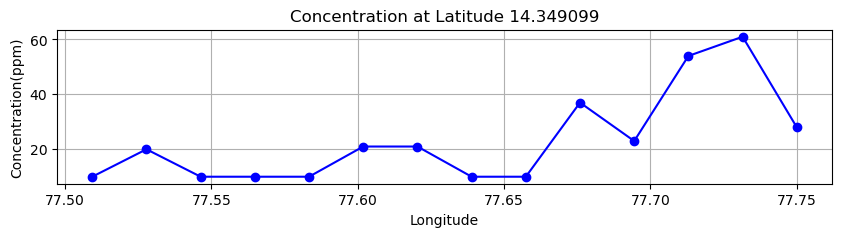

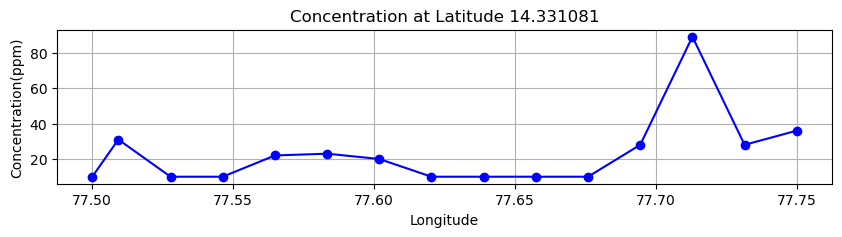

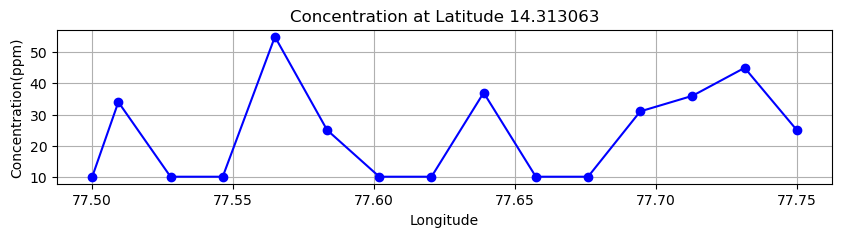

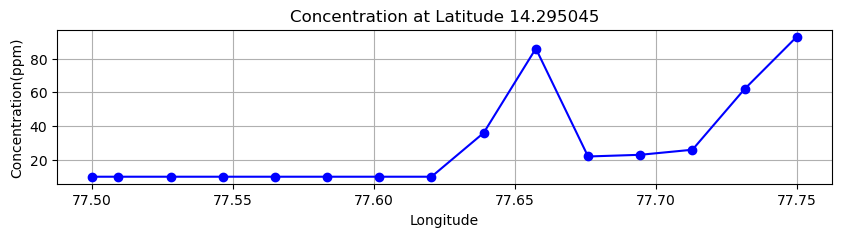

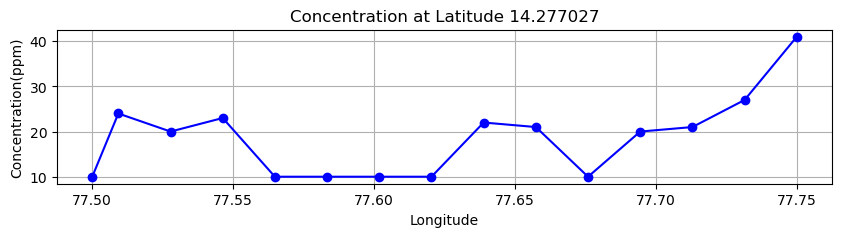

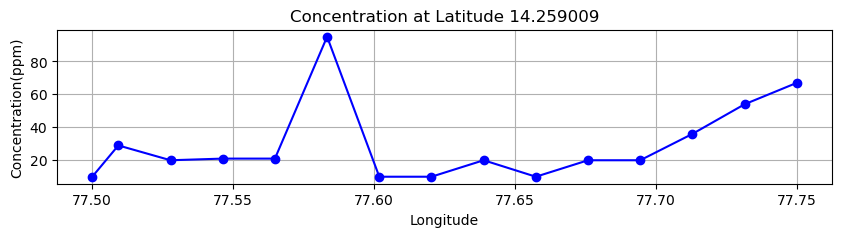

In [63]:
plot_ppm_variation(str_sed_data, 'ag')

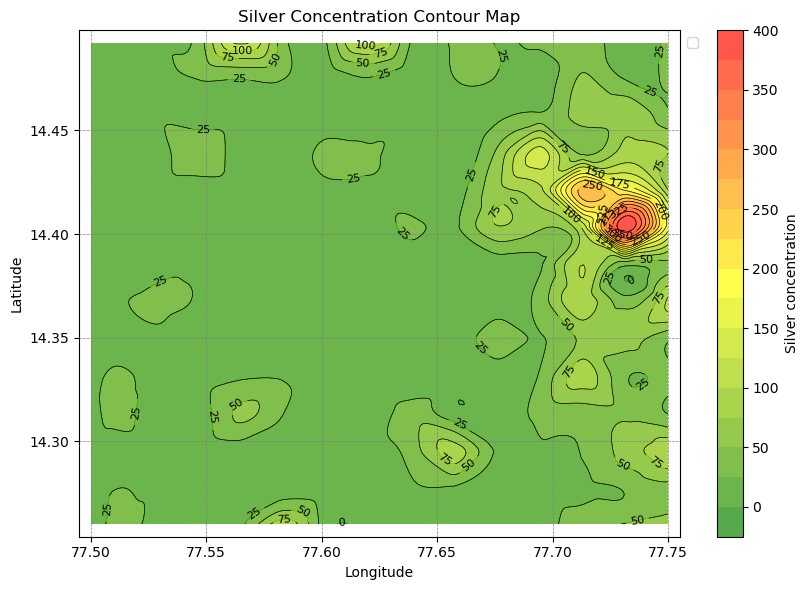

In [139]:
plot_contour(str_sed_data, 'ag', 'Silver', 'Silver Concentration Contour Map')

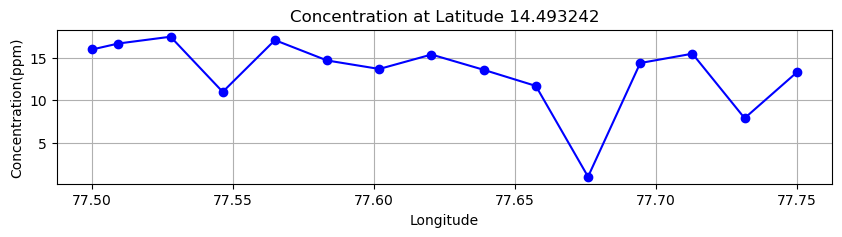

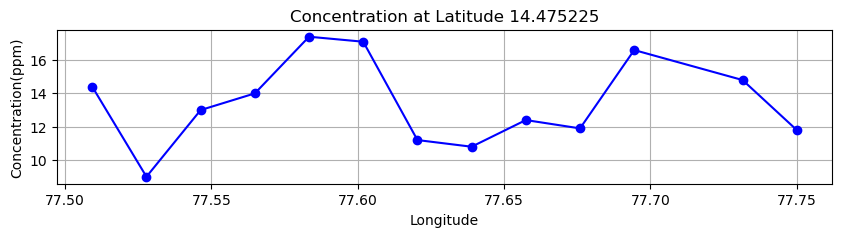

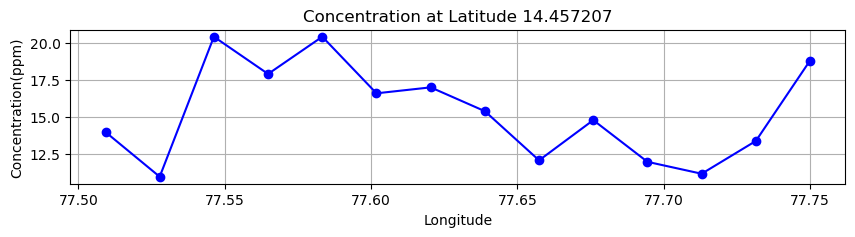

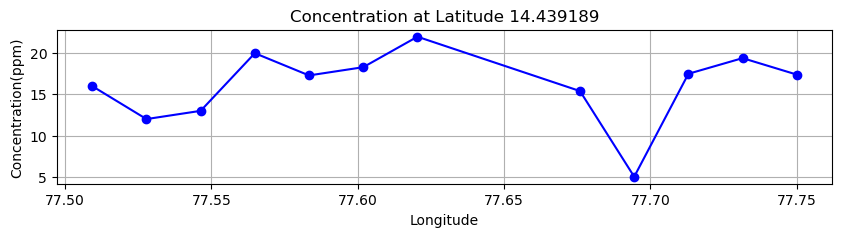

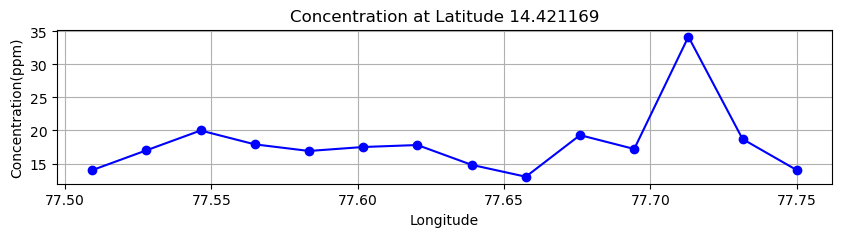

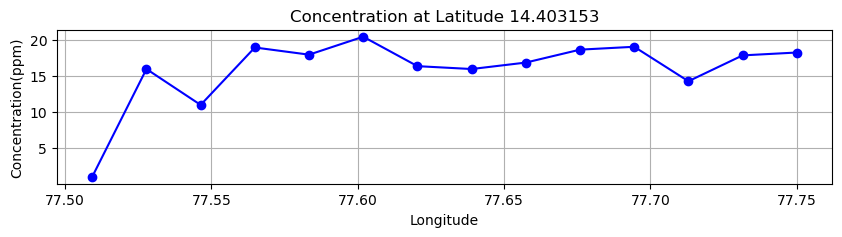

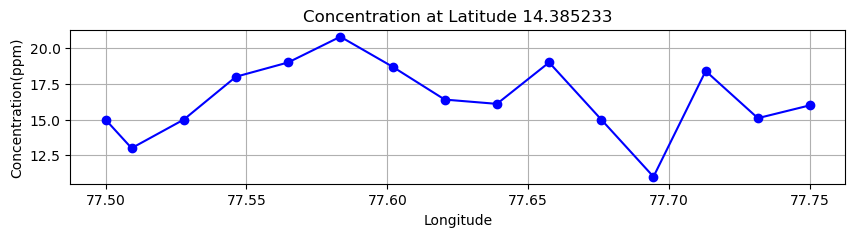

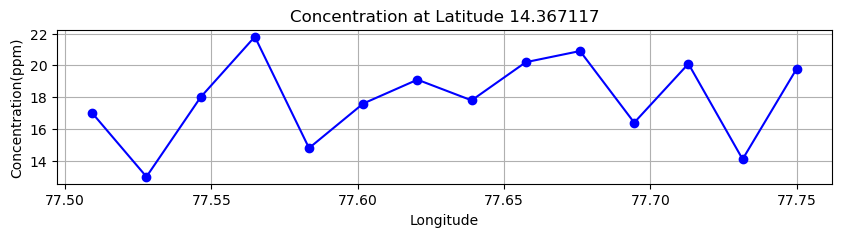

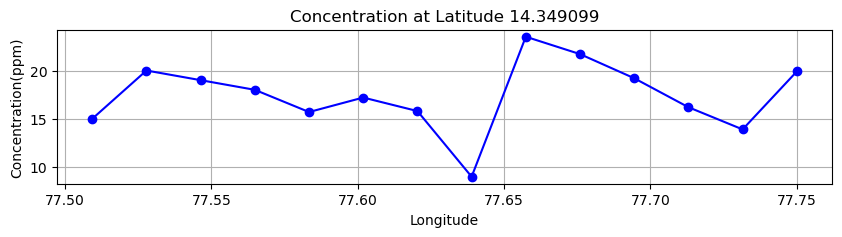

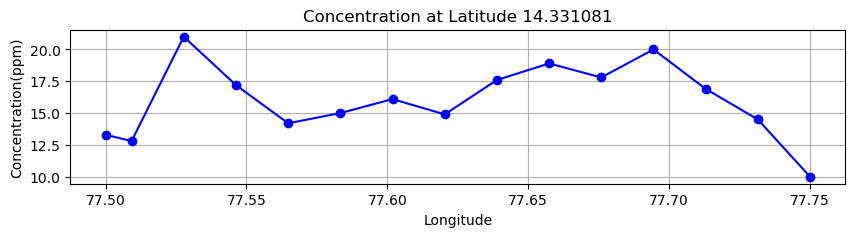

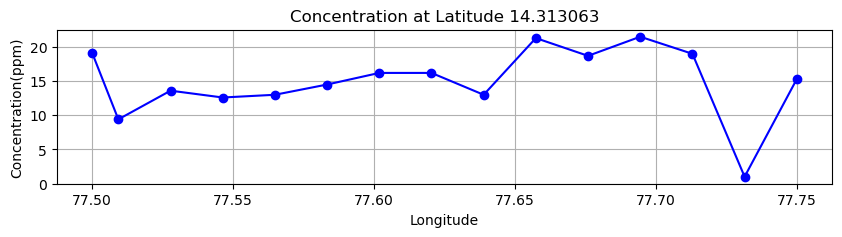

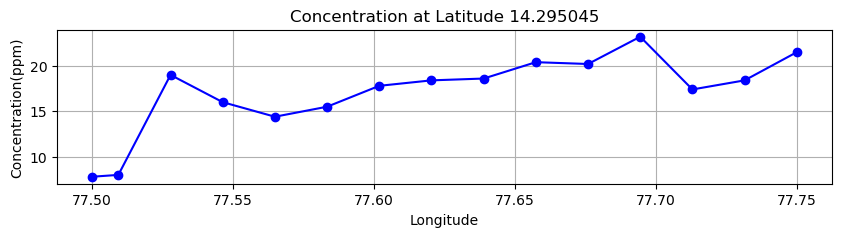

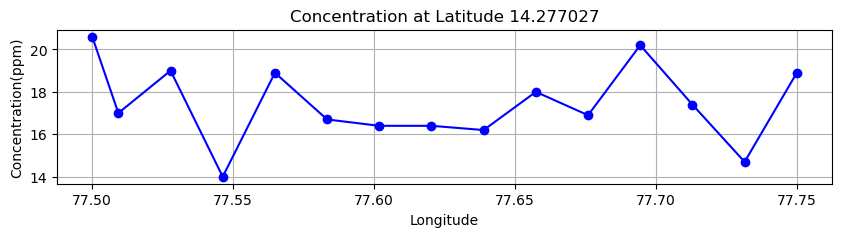

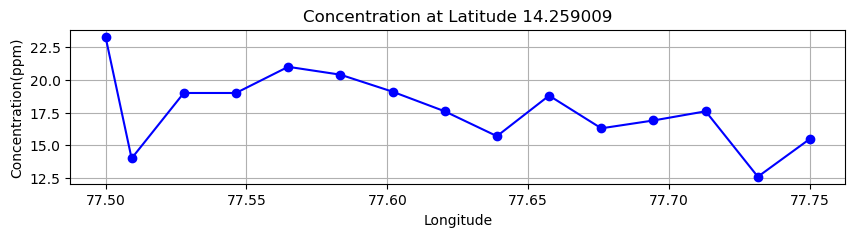

In [64]:
plot_ppm_variation(str_sed_data, 'pb')

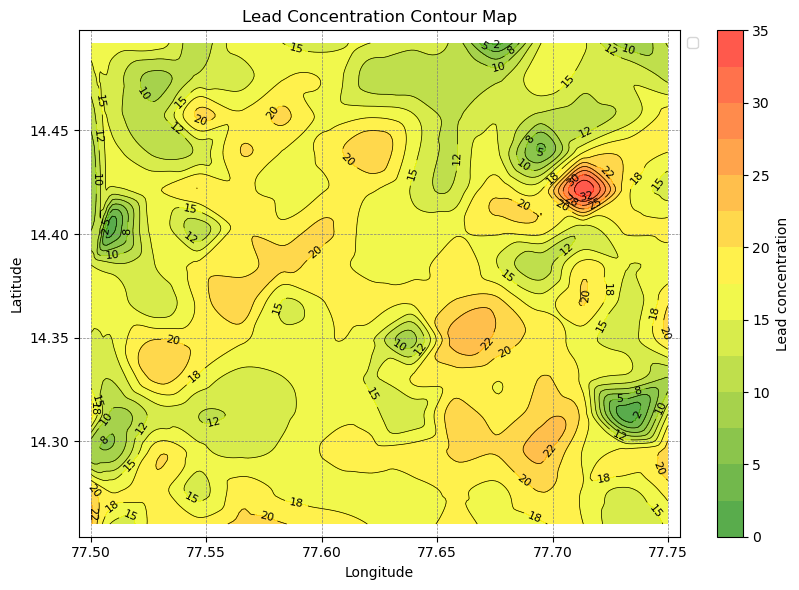

In [140]:
plot_contour(str_sed_data, 'pb', 'Lead', 'Lead Concentration Contour Map')

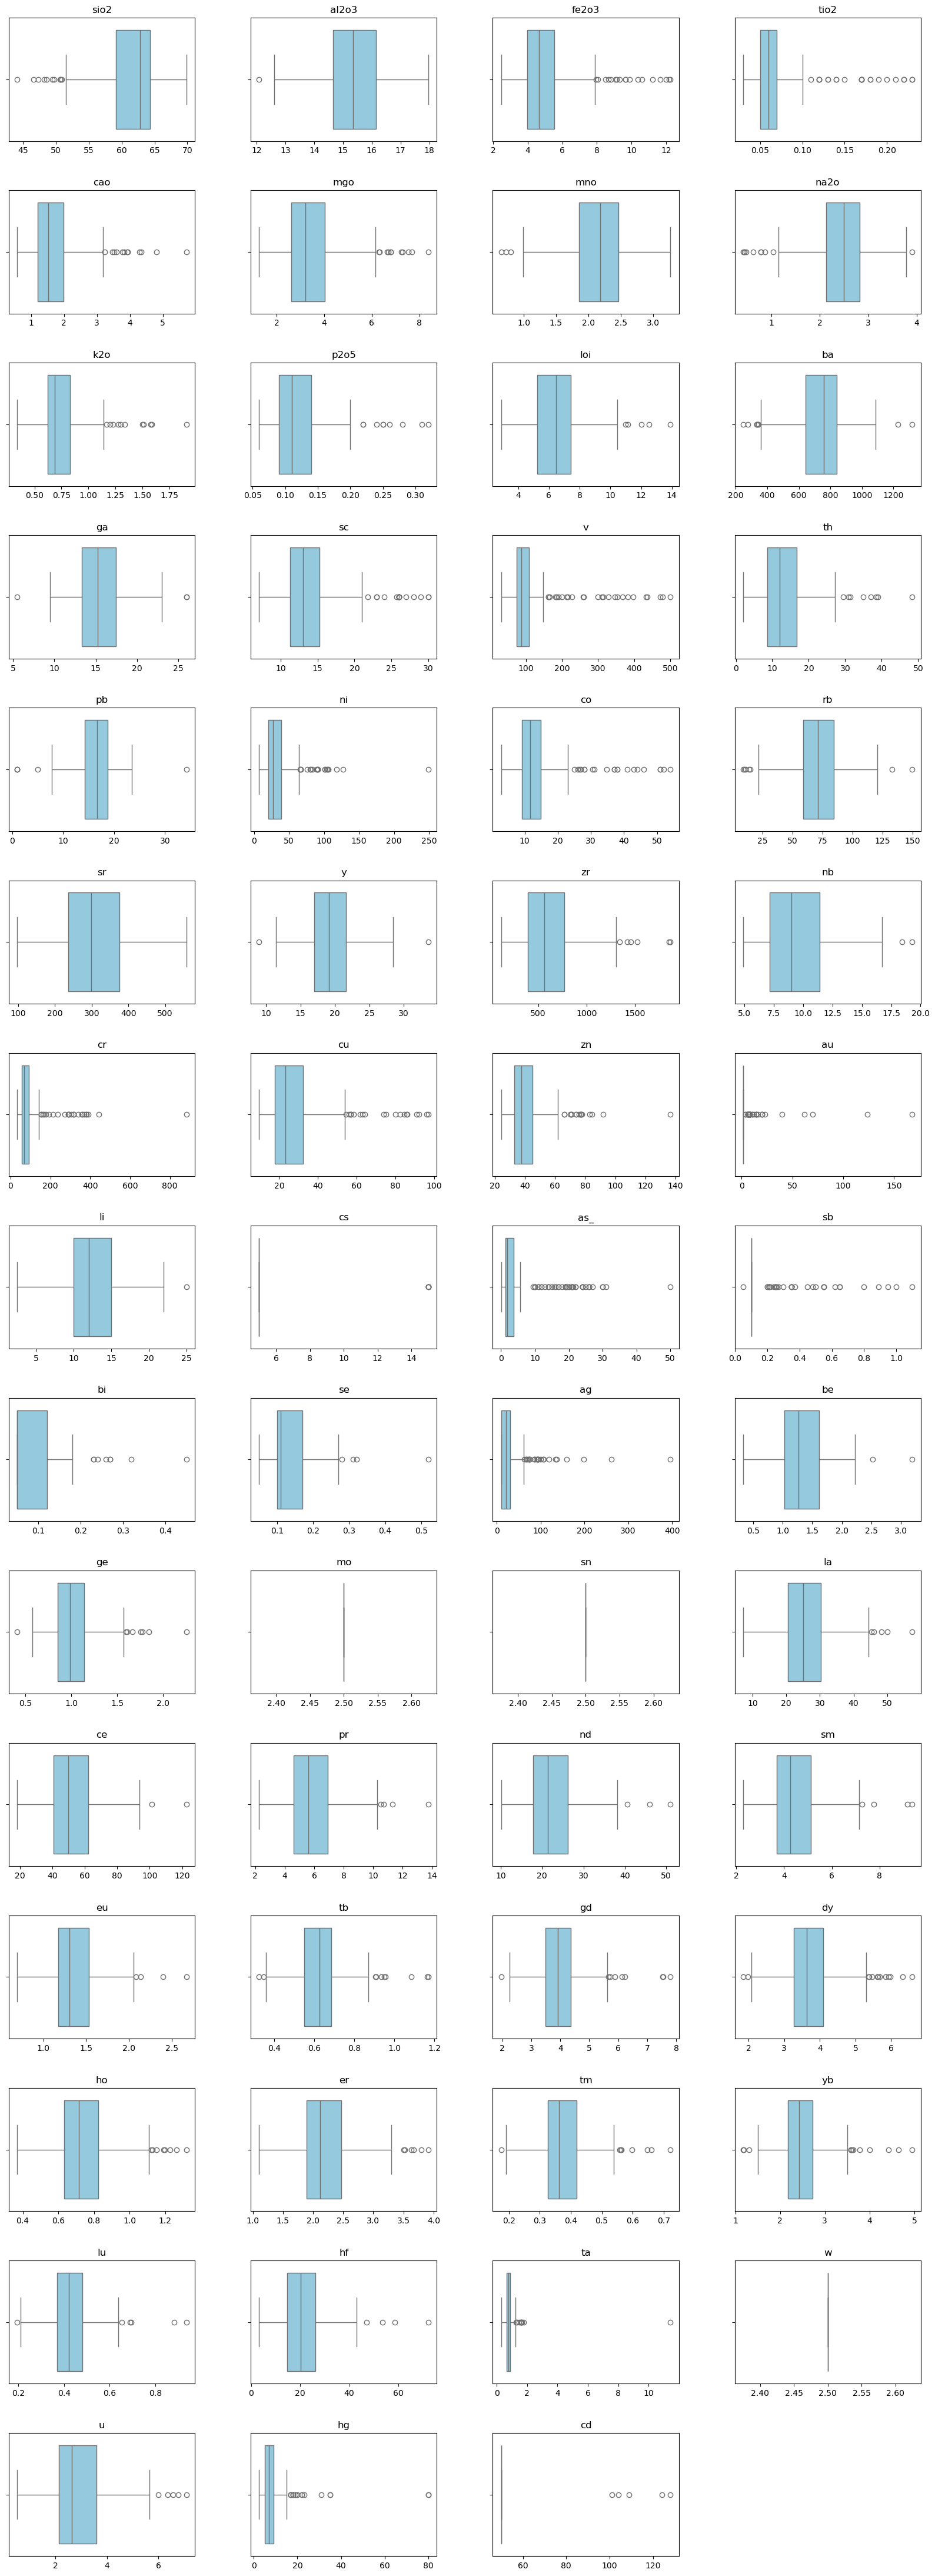

In [131]:
n_elem = len(str_elem)

fig, axes = plt.subplots(nrows=(n_elem+1)//4, 
                         ncols=4, 
                         figsize=(20, 4 * (n_elem//4)))

fig.subplots_adjust(hspace=0.4, wspace=0.3)  # Adjust spacing between plots

# Plot each element in its subplot
for i, (elem, ax) in enumerate(zip(str_sed_data[str_elem].columns, axes.flatten())):
    sns.boxplot(x=str_sed_data[str_elem][elem], 
                ax=ax, 
                color="skyblue")
    ax.set_title(elem)
    ax.set_xlabel('')  # Clear the x-labels if they clutter the plot

#If there are any leftover axes, turn them off
for j in range(i + 1, ((n_elem+1)//4) * 4):
    axes.flatten()[j].set_visible(False)

plt.show()

- Removing elements which have same value for each sample.

In [20]:
str_sed_data.drop(['cs', 'sb', 'mo', 'sn', 'w', 'cd'], axis=1, inplace=True)

- Handling outliers for 'Gold' feature using KNN 

In [21]:
str_sed_data['au'].value_counts()

au
1.5      167
8.0        7
6.0        7
20.0       3
14.0       3
10.0       2
4.0        2
16.0       1
124.0      1
168.0      1
70.0       1
40.0       1
7.0        1
12.0       1
62.0       1
23.0       1
Name: count, dtype: int64

In [22]:
au_outl = str_sed_data[str_sed_data['au'] >= 20]

In [23]:
# Assuming you define 'neighbors' based on some logical geographical proximity
nbrs = NearestNeighbors(n_neighbors=5, 
                        algorithm='ball_tree').fit(str_sed_data[['latitude', 
                                                                 'longitude']])
distances, indices = nbrs.kneighbors(str_sed_data[['latitude', 
                                                   'longitude']])

for index, row in au_outl.iterrows():
    # Calculate the mean of the nearest neighbors excluding the outlier itself
    neighbor_indices = indices[index][1:]  # exclude the first index since it's the point itself
    mean_au = str_sed_data.iloc[neighbor_indices]['au'].mean()
    str_sed_data.at[index, 'au'] = np.round(mean_au, 2)

In [24]:
str_sed_data['au'].value_counts()

au
1.50     168
6.00       7
8.00       7
14.00      3
10.00      2
4.00       2
3.75       1
4.25       1
12.00      1
7.00       1
2.88       1
14.53      1
2.62       1
32.12      1
5.12       1
16.00      1
12.41      1
Name: count, dtype: int64

- Handling outliers using winsorize method

In [25]:
str_elem = elem_list(str_sed_data)

In [26]:
for elem in list(str_sed_data[str_elem].columns):
    if elem != 'au':
        Q1 = str_sed_data[elem].quantile(0.25)
        Q3 = str_sed_data[elem].quantile(0.75)
        IQR = Q3 - Q1
        lwr_bnd = Q1 - (1.5 * IQR)
        upr_bnd = Q3 + (1.5 * IQR)
    
        str_sed_data[elem] = str_sed_data[elem].apply(lambda x: upr_bnd if x > upr_bnd else x)

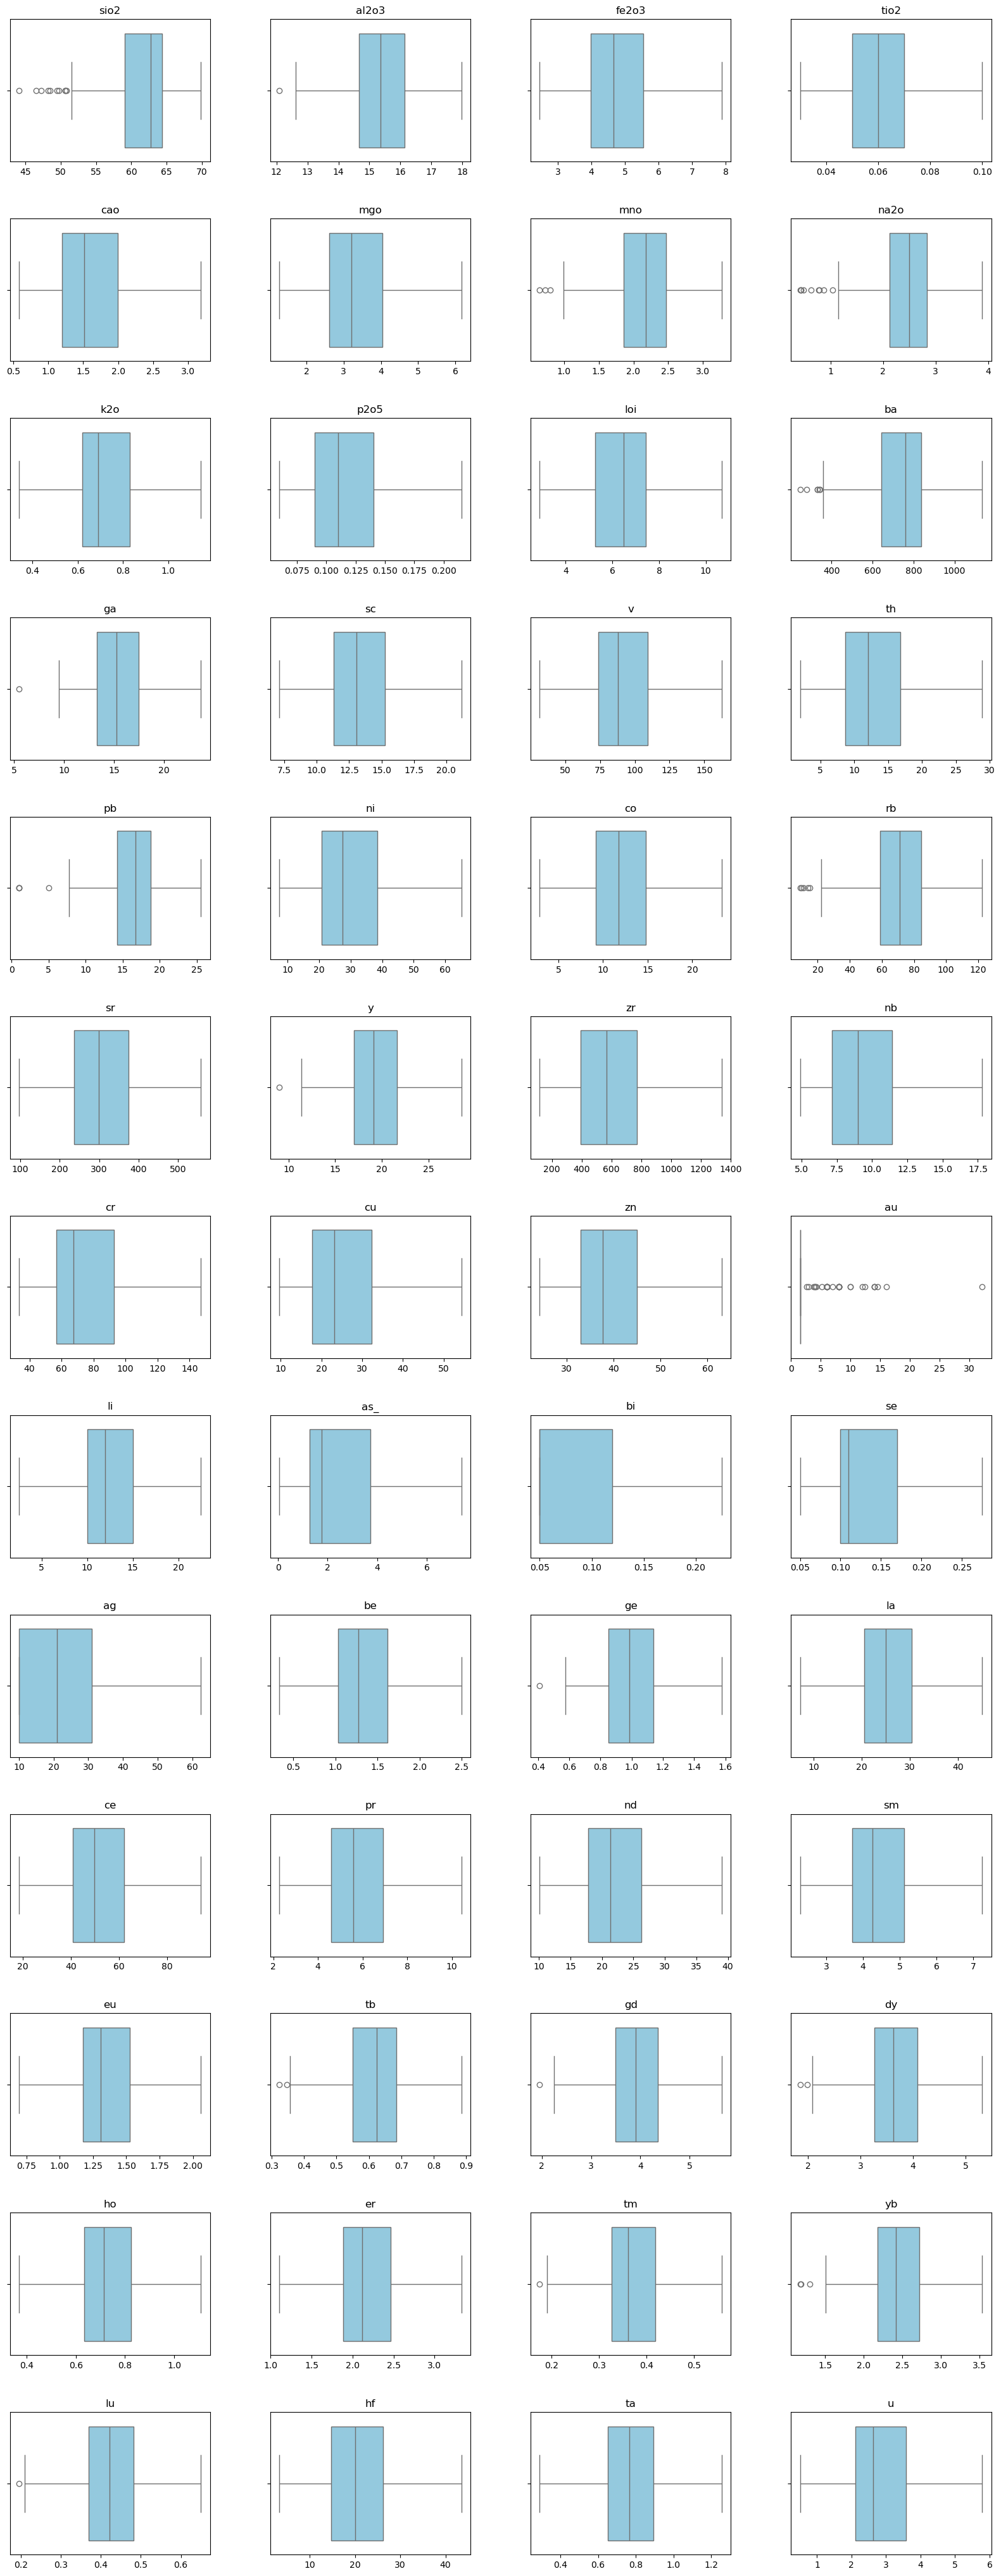

In [160]:
n_elem = len(str_elem)

fig, axes = plt.subplots(nrows=(n_elem+1)//4, 
                         ncols=4, 
                         figsize=(20, 4 * (n_elem//4)))

fig.subplots_adjust(hspace=0.4, wspace=0.3)  # Adjust spacing between plots

# Plot each element in its subplot
for i, (elem, ax) in enumerate(zip(str_sed_data[str_elem].columns, axes.flatten())):
    sns.boxplot(x=str_sed_data[str_elem][elem], 
                ax=ax, 
                color="skyblue")
    ax.set_title(elem)
    ax.set_xlabel('')  # Clear the x-labels if they clutter the plot

#If there are any leftover axes, turn them off
for j in range(i + 1, ((n_elem+1)//4) * 4):
    axes.flatten()[j].set_visible(False)

plt.show()

# Prediction

## Normalize

In [27]:
train_df = str_sed_data[str_elem]
train_df.head()

,sio2,al2o3,fe2o3,tio2,cao,mgo,mno,na2o,k2o,p2o5,...,dy,ho,er,tm,yb,lu,hf,ta,u,hg
0,61.921,14.606,4.51,0.05,2.28,3.24,1.52,2.46,0.61,0.13,...,3.725699,0.730795,2.139445,0.359742,2.290226,0.413697,26.874492,0.677483,3.016905,8.0
1,62.077,13.750,4.22,0.05,2.43,4.14,1.52,2.55,0.64,0.12,...,4.140085,0.783322,2.405519,0.419132,2.891123,0.500104,37.079419,0.774466,3.378550,9.0
2,68.645,13.410,3.02,0.05,1.32,3.19,2.89,3.08,0.75,0.08,...,3.404000,0.651000,1.919000,0.329000,2.323000,0.423000,23.652000,0.715000,3.509000,2.5
3,64.302,14.010,4.08,0.05,1.84,3.24,2.12,2.83,0.75,0.16,...,3.475000,0.655000,2.042000,0.334000,2.322000,0.431000,26.705000,0.832000,4.218000,15.0
4,64.346,14.940,5.25,0.07,1.38,2.59,2.31,2.95,1.05,0.17,...,3.457000,0.650000,1.978000,0.320000,2.311000,0.403000,23.323999,0.739000,3.882000,12.0


In [28]:
target = train_df['as_']
train_df.drop(['as_'], axis=1, inplace=True)

In [30]:
sc = RobustScaler()

norm_data = sc.fit_transform(train_df)

# X_train_norm = pd.DataFrame(norm_data, 
#                             index=X_train.index, 
#                             columns=X_train.columns)

In [31]:
n_samples = len(train_df)
n_features = len(train_df.columns)
train_df = norm_data.reshape((n_samples, n_features, 1))
train_df.shape

(200, 52, 1)

## Train test split

In [32]:
X_train, X_val, y_train, y_val = train_test_split(train_df, 
                                                  target, 
                                                  test_size=0.1, 
                                                  random_state=42, 
                                                  shuffle=True)

## CNN Model

In [306]:
def cnn_model(n_features, learning_rate):
    
    model = Sequential()

    model.add(Conv1D(32, kernel_size=3, padding='same', input_shape=(n_features, 1), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool1D())
    # model.add(Dropout(0.3))

    model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool1D())
    # model.add(Dropout(0.3))

    model.add(Conv1D(128, kernel_size=3, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool1D())
    # model.add(Dropout(0.3))

    # model.add(Conv1D(256, kernel_size=3, padding='same', activation='relu'))
    # model.add(BatchNormalization())
    # model.add(MaxPool1D())
    # model.add(Dropout(0.5))

    # model.add(Conv1D(512, kernel_size=3, padding='same', activation='relu'))
    # model.add(BatchNormalization())
    # model.add(MaxPool1D())
    # model.add(Dropout(0.5))

    # model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    # model.add(Dropout(0.5))
    # model.add(Dense(256, activation='relu'))
    # model.add(Dropout(0.5))
    # model.add(Dense(512, activation='relu'))
    model.add(Dense(1))

    opt = Adam(learning_rate)
    model.compile(optimizer=opt, loss='mae')

    return model

In [307]:
lr = 0.001

# lr_schdlr = LearningRateScheduler(step_decay)

lr_schdlr = ExponentialDecay(initial_learning_rate=lr, 
                             decay_steps=100, 
                             decay_rate=0.96, 
                             staircase=True)

# lr_reduce = ReduceLROnPlateau(monitor='val_loss', 
#                               factor=0.1, 
#                               patience=5, 
#                               min_lr=0.001)

# erly_stp = EarlyStopping(monitor='val_loss', 
#                          verbose=1, 
#                          patience=20, 
#                          mode='min')

In [308]:
model = cnn_model(n_features, lr_schdlr)
model.summary()

Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_145 (Conv1D)                  │ (None, 52, 32)              │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_146              │ (None, 52, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_145 (MaxPooling1D)     │ (None, 26, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_146 (Conv1D)                  │ (None, 26, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_147              │ (None, 26, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_146 (MaxPooling1D)     │ (None, 13, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_147 (Conv1D)                  │ (None, 13, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_148              │ (None, 13, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_147 (MaxPooling1D)     │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_91 (Dropout)                 │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_176 (Dense)                    │ (None, 6, 32)               │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_92 (Dropout)                 │ (None, 6, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_177 (Dense)                    │ (None, 6, 64)               │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_93 (Dropout)                 │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_178 (Dense)                    │ (None, 6, 128)              │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_179 (Dense)                    │ (None, 6, 1)                │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,625 (182.13 KB)

 Trainable params: 46,177 (180.38 KB)

 Non-trainable params: 448 (1.75 KB)

In [309]:
cnnmodel = model.fit(X_train, y_train, 
                     epochs=100, batch_size=32, 
                     validation_data=(X_val, y_val))

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 344ms/step - loss: 2.9575 - val_loss: 2.0689
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 2.1819 - val_loss: 2.0318
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 2.1850 - val_loss: 2.0369
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 2.1080 - val_loss: 2.0365
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 1.9119 - val_loss: 2.0251
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 1.7773 - val_loss: 1.9888
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 1.7328 - val_loss: 1.9419
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 1.8966 - val_loss: 1.9111
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 1.7541 - val_loss: 1.8985
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 1.9510 - val_loss: 1.8616
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 1.7033 - val_loss: 1.8305
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1.7286 - val

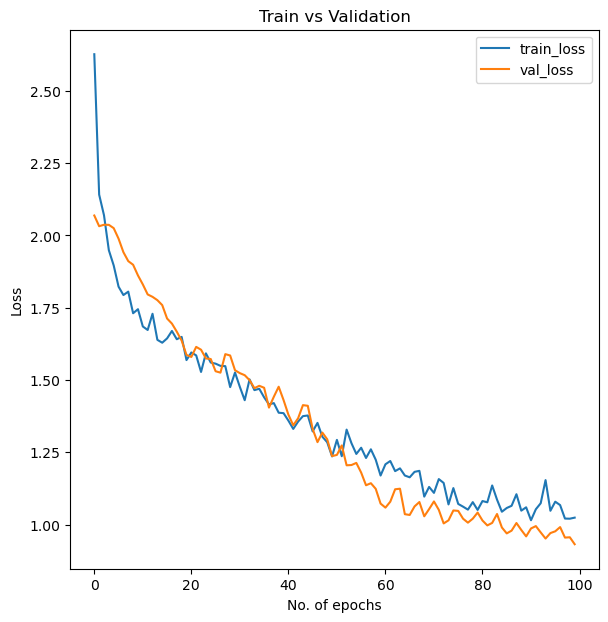

In [310]:
metrics_graph(cnnmodel, 100)